In [1]:
import xarray as xr
import datetime
from IPython.display import HTML,display
import numpy as np

In [2]:
%matplotlib inline

## Open v4 dataset

In [3]:
###REMOTE DATASET
#da=xr.open_dataset('https://weather.rsmas.miami.edu/repository/opendap/synth:0ce7321c-8278-47ef-bb56-7db18c21ea7d:L01JTUlDX0FUX2RhaWx5LjIwMTUtMjAxNl8yZGVnLm5jbWw=/entry.das')

###Open local dataset
da=xr.open_dataset('MIMIC.with_AT.v4.2015-2016.2deg_lattrunc.nc')
#download from here
#http://weather.rsmas.miami.edu/repository/entry/show?entryid=synth%3A1142722f-a386-4c17-a4f6-0f685cd19ae3%3AL01JTUlDX2FnZ190ZW1wL01JTUlDLndpdGhfQVQudjQuMjAxNS0yMDE2LjJkZWdfbGF0dHJ1bmMubmM%3D

In [4]:
import holoviews as hv
from bokeh.models import OpenURL, TapTool, HoverTool


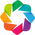

In [5]:
hv.notebook_extension('bokeh')

In [6]:
## make custom function for drawing coastlines

In [7]:
def coastlines(resolution='110m'):
    """ A custom method to plot in cylyndrical equi projection, most useful for
        native projections, geoviews currently supports only Web Mercator in
        bokeh mode.
        other resolution can be 50m
    """
    try:
        import cartopy.io.shapereader as shapereader
        from cartopy.io.shapereader import natural_earth
        import shapefile
        filename = natural_earth(resolution=resolution,category='physical',name='coastline')
    
        sf = shapefile.Reader(filename)
        fields = [x[0] for x in sf.fields][1:]
        records = sf.records()
        shps = [s.points for s in sf.shapes()]
        pls=[]
        for shp in shps:
            lons=[lo for lo,_ in shp]
            lats=[la for _,la in shp]
            pls.append(hv.Path((lons,lats))(style={'color':'Black'}))
        return hv.Overlay(pls)
    except Exception as err:
        print('Overlaying Coastlines not available from holoviews because: {0}'.format(err))


In [8]:
coastline=coastlines() #this may download shape files on first invocation

## Create some tools to attach to the plots 

In [9]:
hover = HoverTool(
        tooltips=[
            ("Time", "@eventtimestr"),
            ("(Lat,Lon)", "(Lon=@eventlonstr{0[.]00}, Lat=@eventlatstr{0[.]00})"),
            ("TPW_TEND","@TPW_TEND"),
            ("TPW","@mosaicTPW")
        ]
    )
#gives info on hovering on a location in the plot

In [10]:
tptool=TapTool()
base_url = 'https://worldview.earthdata.nasa.gov/?p=geographic&l=VIIRS_SNPP_CorrectedReflectance_TrueColor,MODIS_Aqua_CorrectedReflectance_TrueColor(hidden),MODIS_Terra_CorrectedReflectance_TrueColor(hidden),Graticule,AMSR2_Columnar_Water_Vapor_Night(opacity=0.48,palette=rainbow_2,min=45.857742,46.192467,max=49.874477,50.209206,squash),AMSR2_Columnar_Water_Vapor_Day(hidden,opacity=0.3,palette=rainbow_2,min=45.857742,46.192467,max=49.874477,50.209206,squash),Coastlines'
suffix = '&t=@eventdatestr&z=3&v=@eventlonstrW,@eventlatstrS,@eventlonstrE,@eventlatstrN&ab=on&as=@eventdatestr&ae=@eventdatestr1&av=3&al=true'
tptool.callback=OpenURL(url = base_url+suffix)
#on clicking at a point will take to the url specified

In [11]:
stacked=da.stack(timelatlon=['time','lat','lon']) #stack them so that sorting is easy

In [19]:
def threshold_TPW(threshold=50,max_points=100):
    """ Given a threshold of TPW this function return plot corresponding to locations of first 
        max_points values of TPW_TEND in an increasingly sorted array"""
    
    events=stacked.where(stacked['mosaicTPW']>threshold) #threshold based on TPW
    events=events.fillna(-999).sortby('TPW_TEND',ascending=False) # sorting doesnt know how to handle 
                                                     #NANs it might think they are maximums so fill -999 to make 
                                                     #them irrrelavent. if we were searching for mins then fill nans 
                                                     #as a high positive number
    ## add some metadata to data that will make url construction easy 
    df=events.to_dataframe().reset_index()[0:max_points]
    df['eventdatestr']=df.time.apply(lambda x:str(x).split()[0])
    df['eventdatestr1']=df.time.apply(lambda x:str(x+datetime.timedelta(days=1)).split()[0])
    df['eventlonstrE']=df.lon.apply(lambda x:str(x+10.0))
    df['eventlonstrW']=df.lon.apply(lambda x:str(x-10.0))
    df['eventlatstrN']=df.lat.apply(lambda x:str(x+7.5))
    df['eventlatstrS']=df.lat.apply(lambda x:str(x-7.5))
    df['eventtimestr']=df.time.apply(str)
    df['eventlonstr']=df.lon.apply(str)
    df['eventlatstr']=df.lat.apply(str)
    
    vdims=['TPW_TEND','mosaicTPW','eventtimestr','eventlatstr','eventlonstr',
       'eventdatestr','eventdatestr1','eventlonstrW','eventlonstrE','eventlatstrN','eventlatstrS']
    hvd=hv.Dataset(df,kdims=['lon','lat'])
    pts=hvd.to(hv.Points,kdims=['lon','lat'],vdims=vdims).opts(plot={'tools':[hover,tptool]})
    return pts*coastline

In [25]:
%%opts Points  (cmap='viridis' size=0.5) [width=800 height=400 color_index='TPW_TEND' size_index='mosaicTPW' colorbar=True]
threshold_TPW(threshold=50,max_points=1000)

:Overlay
   .Points.I      :Points   [lon,lat]   (TPW_TEND,mosaicTPW,eventtimestr,eventlatstr,eventlonstr,eventdatestr,eventdatestr1,eventlonstrW,eventlonstrE,eventlatstrN,eventlatstrS)
   .Path.I        :Path   [x,y]
   .Path.II       :Path   [x,y]
   .Path.III      :Path   [x,y]
   .Path.IV       :Path   [x,y]
   .Path.V        :Path   [x,y]
   .Path.VI       :Path   [x,y]
   .Path.VII      :Path   [x,y]
   .Path.VIII     :Path   [x,y]
   .Path.IX       :Path   [x,y]
   .Path.X        :Path   [x,y]
   .Path.XI       :Path   [x,y]
   .Path.XII      :Path   [x,y]
   .Path.XIII     :Path   [x,y]
   .Path.XIV      :Path   [x,y]
   .Path.XV       :Path   [x,y]
   .Path.XVI      :Path   [x,y]
   .Path.XVII     :Path   [x,y]
   .Path.XVIII    :Path   [x,y]
   .Path.XIX      :Path   [x,y]
   .Path.XX       :Path   [x,y]
   .Path.XXI      :Path   [x,y]
   .Path.XXII     :Path   [x,y]
   .Path.XXIII    :Path   [x,y]
   .Path.XXIV     :Path   [x,y]
   .Path.XXV      :Path   [x,y]
   .Path.XXVI     :Path   [x,y]
   .Path.XXVII    :Path   [x,y]
   .Path.XXVIII   :Path   [x,y]
   .Path.XXIX     :Path   [x,y]
   .Path.XXX      :Path   [x,y]
   .Path.XXXI     :Path   [x,y]
   .Path.XXXII    :Path   [x,y]
   .Path.XXXIII   :Path   [x,y]
   .Path.XXXIV    :Path   [x,y]
   .Path.XXXV     :Path   [x,y]
   .Path.XXXVI    :Path   [x,y]
   .Path.XXXVII   :Path   [x,y]
   .Path.XXXVIII  :Path   [x,y]
   .Path.XXXIX    :Path   [x,y]
   .Path.XL       :Path   [x,y]
   .Path.XLI      :Path   [x,y]
   .Path.XLII     :Path   [x,y]
   .Path.XLIII    :Path   [x,y]
   .Path.XLIV     :Path   [x,y]
   .Path.XLV      :Path   [x,y]
   .Path.XLVI     :Path   [x,y]
   .Path.XLVII    :Path   [x,y]
   .Path.XLVIII   :Path   [x,y]
   .Path.XLIX     :Path   [x,y]
   .Path.L        :Path   [x,y]
   .Path.LI       :Path   [x,y]
   .Path.LII      :Path   [x,y]
   .Path.LIII     :Path   [x,y]
   .Path.LIV      :Path   [x,y]
   .Path.LV       :Path   [x,y]
   .Path.LVI      :Path   [x,y]
   .Path.LVII     :Path   [x,y]
   .Path.LVIII    :Path   [x,y]
   .Path.LIX      :Path   [x,y]
   .Path.LX       :Path   [x,y]
   .Path.LXI      :Path   [x,y]
   .Path.LXII     :Path   [x,y]
   .Path.LXIII    :Path   [x,y]
   .Path.LXIV     :Path   [x,y]
   .Path.LXV      :Path   [x,y]
   .Path.LXVI     :Path   [x,y]
   .Path.LXVII    :Path   [x,y]
   .Path.LXVIII   :Path   [x,y]
   .Path.LXIX     :Path   [x,y]
   .Path.LXX      :Path   [x,y]
   .Path.LXXI     :Path   [x,y]
   .Path.LXXII    :Path   [x,y]
   .Path.LXXIII   :Path   [x,y]
   .Path.LXXIV    :Path   [x,y]
   .Path.LXXV     :Path   [x,y]
   .Path.LXXVI    :Path   [x,y]
   .Path.LXXVII   :Path   [x,y]
   .Path.LXXVIII  :Path   [x,y]
   .Path.LXXIX    :Path   [x,y]
   .Path.LXXX     :Path   [x,y]
   .Path.LXXXI    :Path   [x,y]
   .Path.LXXXII   :Path   [x,y]
   .Path.LXXXIII  :Path   [x,y]
   .Path.LXXXIV   :Path   [x,y]
   .Path.LXXXV    :Path   [x,y]
   .Path.LXXXVI   :Path   [x,y]
   .Path.LXXXVII  :Path   [x,y]
   .Path.LXXXVIII :Path   [x,y]
   .Path.LXXXIX   :Path   [x,y]
   .Path.XC       :Path   [x,y]
   .Path.XCI      :Path   [x,y]
   .Path.XCII     :Path   [x,y]
   .Path.XCIII    :Path   [x,y]
   .Path.XCIV     :Path   [x,y]
   .Path.XCV      :Path   [x,y]
   .Path.XCVI     :Path   [x,y]
   .Path.XCVII    :Path   [x,y]
   .Path.XCVIII   :Path   [x,y]
   .Path.XCIX     :Path   [x,y]
   .Path.C        :Path   [x,y]
   .Path.CI       :Path   [x,y]
   .Path.CII      :Path   [x,y]
   .Path.CIII     :Path   [x,y]
   .Path.CIV      :Path   [x,y]
   .Path.CV       :Path   [x,y]
   .Path.CVI      :Path   [x,y]
   .Path.CVII     :Path   [x,y]
   .Path.CVIII    :Path   [x,y]
   .Path.CIX      :Path   [x,y]
   .Path.CX       :Path   [x,y]
   .Path.CXI      :Path   [x,y]
   .Path.CXII     :Path   [x,y]
   .Path.CXIII    :Path   [x,y]
   .Path.CXIV     :Path   [x,y]
   .Path.CXV      :Path   [x,y]
   .Path.CXVI     :Path   [x,y]
   .Path.CXVII    :Path   [x,y]
   .Path.CXVIII   :Path   [x,y]
   .Path.CXIX     :Path   [x,y]
   .Pa

In [14]:
#Note the color is based on magnitude of TPW_TEND and size of points are based on TPW 
#notice the box zoom, scroll zoom options , that can be used to zoom in

In [30]:
%%opts Overlay [width=800 height=500 tools=[hover,tptool] toolbar='above']
%%opts Points  (cmap='viridis' size=0.4) [color_index='TPW_TEND' size_index='mosaicTPW' colorbar=True colorbar_position='bottom']
hv.DynamicMap(threshold_TPW, kdims=['threshold', 'max_points']).redim.range(threshold=(40,70),max_points=(100,2000))

:DynamicMap   [threshold,max_points]

In [16]:
#if you have lot of computer resources can make a static map of above dynamic map
#that can also be broswed in a HTML view or nbviewer
#thresholds = range(40, 70, 10)
#max_numbers = range(100,5000, 100)

#points_map = {(t, n): threshold_TPW(t,n) for t in thresholds for n in max_numbers}

#kdims = [('threshold', 'TPW threshold'), ('max_number', 'Max number')]
#holomap = hv.HoloMap(points_map, kdims=kdims)
#holomap